# Projet de méthodes matricielles pour le calcul intensif
## P.A. Boucard
Le projet est divisé en 3 parties globalement indépendantes :
- Comparaison de la convergence de solveurs itératifs basée sur les méthodes de stationnarité (Jacobi, Gausse-Seidel et SOR)
- Méthode multigrille pour le problème de Poisson
- Résolution de problèmes non-linéaires

Le rendu du projet se fera sous la forme d'un notebook jupyter qui comprendra les réponses aux questions posées et intègrera le code Python (très commenté !). Les fichiers seront nommés **Projet_NOM_Prénom.ipynb**.

## Comparaison de la convergence de solveurs itératifs

### Résolution numérique de l'équation de la chaleur unidimensionnelle

On cherche à résoudre l'équation $u''(x)+f(x), x \in [0,1]$ avec $u(0)=u(1)=0$.

On va pour cela introduire la méthode de discrétisation dite par différences finies. Soit $n \in \mathbb{N}$, on définit $h = 1/(n + 1)$ le pas de discrétisation, c.à.d. la distance entre deux points de discrétisation, et pour $ i=0,...,n+1$ on définit les points de discrétisation $x_i =ih$.

En imposant $u_0=0$ en $x_0$ et $u_n=0$ en $x_n$, on peut montrer que le système à résoudre s'écrit : $\mathbf{K}\mathbf{u}=\mathbf{b}$ ou $b$ dépend du choix de $f$.

La matrice $\mathbf{K}$ est tridiagonale, symétrique définie positive et telle que $$\begin{aligned}
 K_{i,i} &= \frac{2}{h^2}, \forall i=1,...,n \\
 K_{i,j} &= \frac{-1}{h^2}, \forall i=1,...,n, j=i\pm1 \\
 K_{i,j} &= 0, \forall i=1,...,n, |i-j|\gt 1
\end{aligned}$$
    
Dans la suite on choisit $f(x)=\pi^2 sin(\pi x)$, la solution exacte du problème est donc $u(x)=sin(\pi x)$.

#### Question :
*Construire la matrice $\mathbf{K}$, et le second membre $\mathbf{b}$, ainsi que la solution exacte pour $n$ quelconque. En utilisant le solveur directe de numpy, montrer numériquement la convergence d’ordre 2 pour la norme $\|\;\;\|_{\infty}$ (on pourra tracer le logarithme de la norme infinie entre la solution approchée et la solution exacte en fonction du logarithme de $h$, et calculer la pente de la droite qui en résulte).*

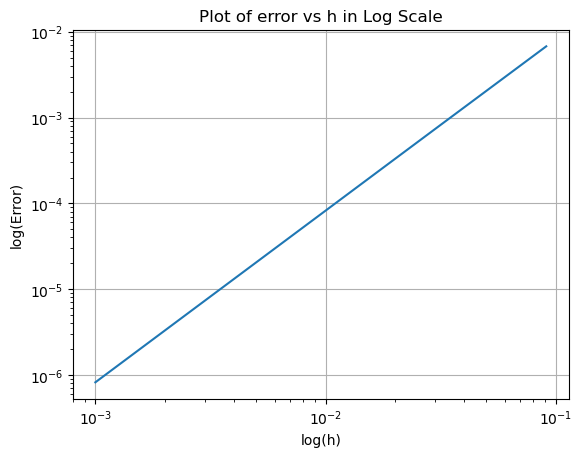

Slope of the curve: [[1.99948476]] which is equal to the expected value of 2


In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def create_band_matrix(n,p, Kii, Kij):
    '''Function to create band matrices'''
    
    A=np.diag(np.ones(n)*Kii)
    for j in range(-p, 0):
        A += np.diag(np.ones(n+j)*Kij,j)
    for j in range(1,p+1):
        A += np.diag(np.ones(n-j)*Kij,j)
    return A

def lavsex(n, p=1, sol = False):
    '''Function to compare the exact solution with the 
    numpy exact solver based on specified norm'''    
    
    # Step size
    h = (1/(n+1))
    
    # K entries
    Kii = 2/(h**2)
    Kij = -1/(h**2)
    
    # For vector computations
    n_range = np.array(range(1,n+1))
    
    #Banded Matrix
    K = create_band_matrix(n,p, Kii, Kij)
    
    # b is based on f
    f = (np.pi**2) * np.sin(np.pi*h*n_range)
    b = f.copy()
    # Exact solution
    u_ex = np.sin(np.pi * h*n_range)
    if sol == True:
    #Approximate Solution
        u_app = la.solve(K, b)
    # Error an its norm
        error = u_ex - u_app
        n_error = la.norm(error, np.inf)    
        return n_error
    else:
        return K, b, u_ex

# Range of n
n = np.linspace(10, 1000, 49).astype(int)

# Step size
h = 1/(n+1)

# Error for each n range
n_error = [lavsex(n[i], 1, True) for i in range(n.shape[0])]

# Plotting the slope in log scale
plt.figure
plt.loglog(h, n_error)
plt.title('Plot of error vs h in Log Scale')
plt.xlabel('log(h)')
plt.ylabel('log(Error)')
plt.grid()
plt.show()
# Print the slope of the curve
model = LinearRegression().fit(np.log(h).reshape(-1,1), np.log(n_error).reshape(-1,1))
print(f"Slope of the curve: {model.coef_} which is equal to the expected value of 2")


### Comparaison de solveurs itératifs

On propose de reprendre le méthodes de stationnarité qui reposent sur le partitionnement de la matrice
${\mathbf{K}}={\mathbf{M}}-{\mathbf{N}}$
avec ${\mathbf{M}}$ facile à inverser. On réécrit le système : ${\mathbf{M}}{\mathbf{x}}= {\mathbf{N}}{\mathbf{x}}+{\mathbf{b}}$

On utilise un schéma de type point fixe : ${\mathbf{M}}{\mathbf{x}}_{i+1} = {\mathbf{N}}{\mathbf{x}}_i+{\mathbf{b}}$ qui converge dès que $\rho({\mathbf{M}}^{-1}{\mathbf{N}})<1$.

Le principal critère est lié au résidu, on itère tant que $\|{\mathbf{r}}_i\|>\varepsilon\|{\mathbf{b}}\|$

On écrit ${\mathbf{K}}={\mathbf{D}}-{\mathbf{E}}-{\mathbf{F}}$
avec ${\mathbf{D}}$ diagonale ${\mathbf{E}}$
strictement triangulaire inférieure et ${\mathbf{F}}$
strictement triangulaire supérieure. On va alors étudier les 3 méthodes suivantes :

-   Jacobi : ${\mathbf{M}}={\mathbf{D}}$ et
    ${\mathbf{N}}={\mathbf{E}}+{\mathbf{F}}$
    ,

-   Gauss-Seidel :
    ${\mathbf{M}}={\mathbf{D}}-{\mathbf{E}}$
    et ${\mathbf{N}}={\mathbf{F}}$,
    
-   Sur-relaxation, $\omega$ paramètre réel:
    ${\mathbf{M}}={\frac{1}{\omega}\mathbf{D}}-\mathbf{E}$
    et
    ${\mathbf{N}}=(\frac{1}{\omega}-1){\mathbf{D}}+{\mathbf{F}}$
    (en Anglais on parle de *successive overrelaxation* (SOR)),
    
    ### Comparison of iterative solvers

We propose to use the stationarity methods based on the partitioning of the matrix
${\mathbf{K}}={\mathbf{M}}-{\mathbf{N}}$
with ${\mathbf{M}}$ easy to invert. We rewrite the system: ${\mathbf{M}}{\mathbf{x}}= {\mathbf{N}}{\mathbf{x}}+{\mathbf{b}}$.

We use a fixed point scheme: ${\mathbf{M}}{\mathbf{x}}_{i+1} = {\mathbf{N}}{\mathbf{x}}_i+{\mathbf{b}}$ which converges as soon as $\rho({\mathbf{M}}^{-1}{\mathbf{N}})<1$.

The main criterion is related to the residue, we iterate as long as $\|{\mathbf{r}}_i\|>\varepsilon|{\mathbf{b}}\|$

On écrit ${\mathbf{K}}={\mathbf{D}}-{\mathbf{E}}-{\mathbf{F}}$
with ${\mathbf{D}}$ diagonal ${\mathbf{E}}$
strictly lower triangular and ${\mathbf{F}}$
strictly upper triangular. We will then study the 3 following methods:

- Jacobi: ${\mathbf{M}}={\mathbf{D}}$ and
    ${\mathbf{N}}={\mathbf{E}}+{\mathbf{F}}$
    ,

- Gauss-Seidel:
    ${\mathbf{M}}={\mathbf{D}}-{\mathbf{E}}$
    et ${\mathbf{N}}={\mathbf{F}}$,
    
- Over-relaxation, ${\omega}$ real parameter:
    ${\mathbf{M}}={\frac{1}{\omega}\mathbf{D}}-\mathbf{E}$
    and
    ${\mathbf{N}}=(\frac{1}{\omega}-1){\mathbf{D}}+{\mathbf{F}}$
    (in English we speak of *successive overrelaxation* (SOR)),

Translated with www.DeepL.com/Translator (free version)

#### Question :
*Construire une fonction dont les paramètres sont $\mathbf{K}, \mathbf{b}, \epsilon, \mathbf{x}_{ex}$ et $\mathbf{x_0}$ et qui calcule, avec la méthode de Jacobi, la solution approchée du système linéaire $\mathbf{K}\mathbf{x}=\mathbf{b}$ et retourne le résidu ($\|{\mathbf{r}}_i\|$) et l’erreur ($\|{\mathbf{x}} - {\mathbf{x}}_i\|$) à chaque itération $i$ de la méthode (${\mathbf{x}}$ sera obtenu par une méthode directe).*

*Vérifier pour le problème associé à la discrétisation de l'équation de la chaleur (on prendra $n=50$) que $\rho({\mathbf{M}}^{-1}{\mathbf{N}})<1$.*

*Construire pour $\epsilon = 10^{−6}$ et deux choix différents de $\mathbf{x_0}$ (par exemple, $\mathbf{x_0}$ nul et $\mathbf{x_0}$ dont toutes les composantes sont égales à 1) un graphique, avec une échelle semilog, donnant l'évolution de l’erreur au cours des itérations.*
*Construct a function whose parameters are $\mathbf{K}, \mathbf{b}, \epsilon, \mathbf{x}_{ex}$ and $\mathbf{x_0}$ and which computes, with the Jacobi method, the approximate solution of the linear system $\mathbf{K}\mathbf{x}=\mathbf{b}$ and returns the residual ($\|{mathbf{r}}_i|$) and the error ($\|{mathbf{x}} - {\mathbf{x}}_i|$) at each iteration $i$ of the method ($${mathbf{x}}$ will be obtained by a direct method). *

*Verify for the problem associated with the discretization of the heat equation (we will take $n=50$) that $\rho({\mathbf{M}}^{-1}{\mathbf{N}})<1$.*

*Construct for $\epsilon = 10^{-6}$ and two different choices of $\mathbf{x_0}$ (for example, $\mathbf{x_0}$ null and $\mathbf{x_0}$ with all components equal to 1) a graph, with a semilog scale, giving the evolution of the error during the iterations.*

Translated with www.DeepL.com/Translator (free version)


Number of iterations for `ones` initialization: 6593
Number of iterations for `zeros` initialization: 7278
Number of iterations for `random` initialization: 8770


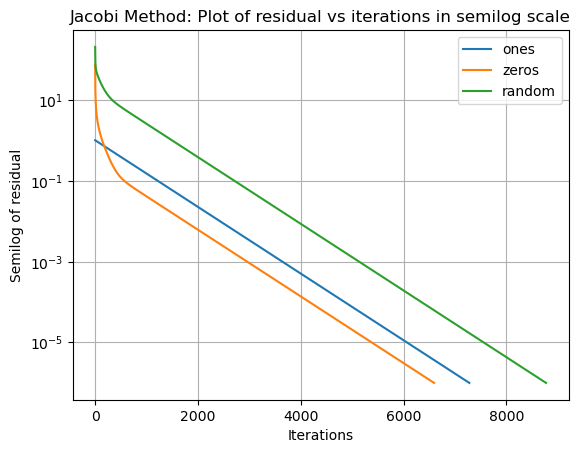

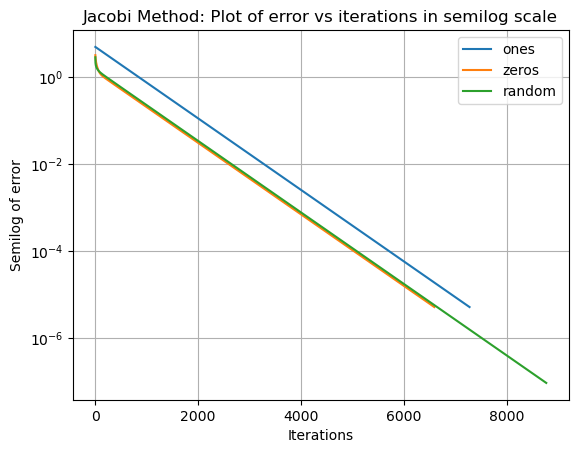

In [2]:
import numpy as np
from numpy import linalg as la

def jacobi(A, b, u_ex, nmax_iter, epsilon ,n, arg):
    '''Function for Jacobi Method'''
    
    F = -np.triu(A, k = 1)
    E = -np.tril(A, k = -1)
    D = A + F + E
    M = D
    Minv = np.diag(1/np.diag(M))
    N = F + E
    
    # Arguments for different initializations
    
    x = np.ones_like(b) if arg == 'ones' else np.zeros_like(b) if arg =='zeros' else np.random.random(len(b))

    iter = 0
    res = la.norm(A@x - b,n)/la.norm(b,n)
    r = np.array([res])
    er = np.array([la.norm(u_ex - x,n)])
    
    while iter < nmax_iter and res > epsilon:
        x = Minv @ (N @x + b)
        res = la.norm(A@x -b, n)/la.norm(b,n)
        r = np.append(r, res)
        er = np.append(er, la.norm(u_ex - x, n))
        iter+=1
        
    return x, iter, res, r, er

##########################
#### Example Solution ####
##########################
# Parameters
n = 50 # Size of the discretizations
K, b, u_ex = lavsex(n)
u_ex = la.solve(K,b) # u_ex from la.solve
max_iter = 10000 
precision = 1e-6
norm = 2
arg = ['ones', 'zeros', 'random'] # Initialization types

# Solution with all three arguments
x1, n_iter1j, error1, r1, er1 = jacobi(K, b,u_ex, max_iter, precision, norm, arg[0])
x0, n_iter0j, error0, r0, er0 = jacobi(K, b,u_ex, max_iter, precision, norm, arg[1])
xr, n_iterrj, errorr, rr, err = jacobi(K, b,u_ex, max_iter, precision, norm, arg[2])

# Number of Iterations taken by each initializations
print(f"Number of iterations for `ones` initialization: {n_iter1j}")
print(f"Number of iterations for `zeros` initialization: {n_iter0j}")
print(f"Number of iterations for `random` initialization: {n_iterrj}")

# Plotting the error and the residuals
plt.figure()
plt.title('Jacobi Method: Plot of residual vs iterations in semilog scale')
plt.semilogy(r0)
plt.semilogy(r1)
plt.semilogy(rr)
plt.legend(arg)
plt.xlabel('Iterations')
plt.ylabel('Semilog of residual')
plt.grid()
plt.show()

plt.figure()
plt.title('Jacobi Method: Plot of error vs iterations in semilog scale')
plt.semilogy(er0)
plt.semilogy(er1)
plt.semilogy(err)    
plt.legend(arg)
plt.xlabel('Iterations')
plt.ylabel('Semilog of error')
plt.grid()
plt.show()


#### Question :

*Reprendre la question précédente pour la méthode de Gauss-Seidel*

Number of iterations for `ones` initialization: 3299
Number of iterations for `zeros` initialization: 3640
Number of iterations for `random` initialization: 3390


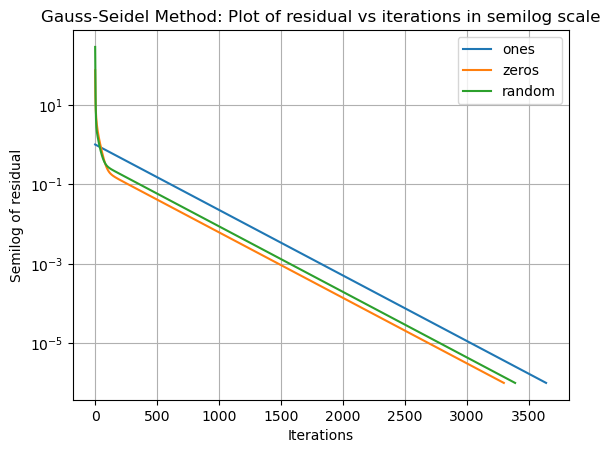

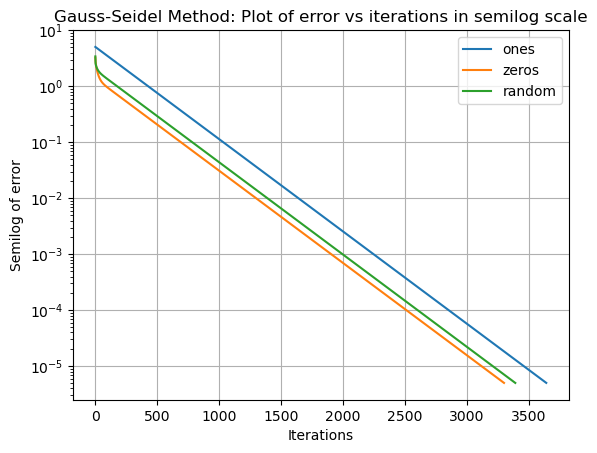

In [3]:
import numpy as np
from numpy import linalg as la

def gauss_seidel(A, b, u_ex, nmax_iter, epsilon,n, arg):
    '''Function for Gauss-Seidel Method'''
    
    F = -np.triu(A, k = 1)
    E = -np.tril(A, k = -1)
    D = A + F + E
    M = D - E
    Minv = la.inv(M)
    N = F
    
    # Arguments for different initializations
    
    x = np.ones_like(b) if arg == 'ones' else np.zeros_like(b) if arg =='zeros' else np.random.random(len(b))

    iter = 0
    res = la.norm(A@x - b,n)/la.norm(b,n)
    r = np.array([res])
    er = np.array([la.norm(u_ex - x,n)])
    
    while iter < nmax_iter and res > epsilon:
        x = Minv @ (N @x + b)
        res = la.norm(A@x -b, n)/la.norm(b,n)
        r = np.append(r, res)
        er = np.append(er, la.norm(u_ex - x, n))
        iter+=1
        
    return x, iter, res, r, er

##########################
#### Example Solution ####
##########################
# Parameters
n = 50 # Size of the discretizations
K, b, u_ex = lavsex(n)
u_ex = la.solve(K,b) # u_ex from la.solve
max_iter = 10000 
precision = 1e-6
norm = 2
arg = ['ones', 'zeros', 'random'] # Initialization types

# Solution with all three arguments
x1, n_iter1s, error1, r1, er1 = gauss_seidel(K, b, u_ex, max_iter, precision, norm, arg[0])
x0, n_iter0s, error0, r0, er0 = gauss_seidel(K, b, u_ex, max_iter, precision, norm, arg[1])
xr, n_iterrs, errorr, rr, err = gauss_seidel(K, b, u_ex, max_iter, precision, norm, arg[2])

# Number of Iterations taken by each initializations
print(f"Number of iterations for `ones` initialization: {n_iter1s}")
print(f"Number of iterations for `zeros` initialization: {n_iter0s}")
print(f"Number of iterations for `random` initialization: {n_iterrs}")

# Plotting the error and the residuals
plt.figure()
plt.title('Gauss-Seidel Method: Plot of residual vs iterations in semilog scale')
plt.semilogy(r0)
plt.semilogy(r1)
plt.semilogy(rr)
plt.legend(arg)
plt.xlabel('Iterations')
plt.ylabel('Semilog of residual')
plt.grid()
plt.show()

plt.figure()
plt.title('Gauss-Seidel Method: Plot of error vs iterations in semilog scale')
plt.semilogy(er0)
plt.semilogy(er1)
plt.semilogy(err)    
plt.legend(arg)
plt.xlabel('Iterations')
plt.ylabel('Semilog of error')
plt.grid()
plt.show()


#### Question :

*On s’intéresse maintenant à la méthode SOR : ${\mathbf{M}}={\frac{1}{\omega}\mathbf{D}}-\mathbf{E}$
    et
    ${\mathbf{N}}=(\frac{1}{\omega}-1){\mathbf{D}}+{\mathbf{F}}$*

*On suppose que $0 \lt \omega \lt 2$*

*Déterminer numériquement une approximation de la valeur de $\omega$ minimisant $\rho({\mathbf{M}}^{-1}{\mathbf{N}})$.*

*Reprendre la question précédente avec la valeur de $\omega$ déterminée.*

The optimum omega is 1.884018151757213 which minimizes the spectral radius

Iterations taken with `ones` initialization: 154
Iterations taken with `zeros` initialization: 150
Iterations taken with `random` initialization: 154


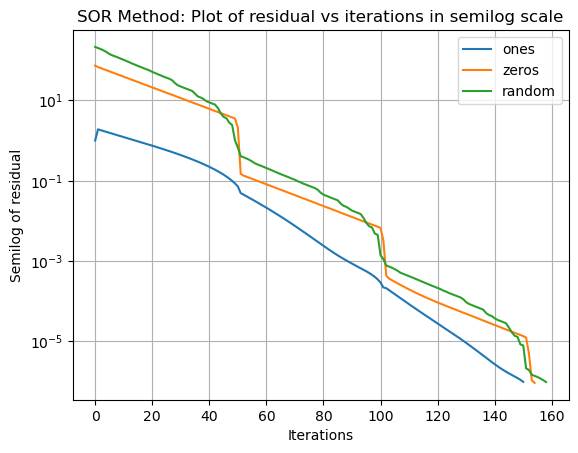

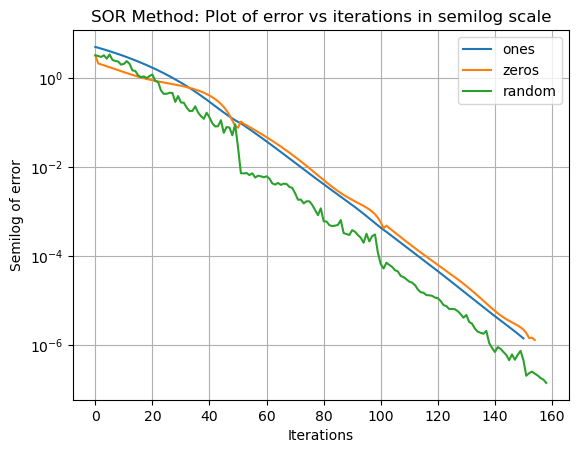

In [4]:
import numpy as np
from numpy import linalg as la
import scipy as sc

def omega_optim(A,b):
    '''Minimization of the function `fun` which reduces \omega'''
    
    F = -np.triu(A, k = 1)
    E = -np.tril(A, k = -1)
    D = A + F + E
    
    # Function using lambda
    fun = lambda x: np.max(abs(la.eigvals((la.inv(D/x - E))@((1/x-1)*D + F))))
    
    # Minimization using scipy, without displaying convergence results
    bounds = [(0.01,1.99)]
    mins = sc.optimize.minimize(fun, 1, bounds = bounds)
    return mins.x[0]


def SOR(A, b, u_ex, nmax_iter, epsilon, n, omg, arg):
    '''Function for SOR Method'''
    
    F = -np.triu(A, k = 1)
    E = -np.tril(A, k = -1)
    
    D = A + F + E
    M = D/omg - E
    Minv = la.inv(M)
    N = (1/omg-1)*D + F
    
    # Arguments for different 
    x = np.ones_like(b) if arg == 'ones' else np.zeros_like(b) if arg =='zeros' else np.random.random(len(b))

    iter = 0
    res = la.norm(A@x - b,n)/la.norm(b,n)
    r = np.array([res])
    er = np.array([la.norm(u_ex - x,n)])
    
    while iter < nmax_iter and res > epsilon:
        x = Minv @ (N @x + b)
        res = la.norm(A@x -b, n)/la.norm(b,n)
        r = np.append(r, res)
        er = np.append(er, la.norm(u_ex - x, n))
        iter+=1
        
    return x, iter, res, r, er

##########################
#### Example Solution ####
##########################
# Parameters
n = 50 # Size of the discretizations
K, b, u_ex = lavsex(n)
u_ex = la.solve(K,b) # u_ex from la.solve
max_iter = 10000 
precision = 1e-6
norm = 2
arg = ['ones', 'zeros', 'random'] # Initialization types
omg = omega_optim(K,b) # Finding Optimum omega
print(f'The optimum omega is {omg} which minimizes the spectral radius\n')

# Solution with all three arguments
x1, n_iter1o, error1, r1, er1 = SOR(K, b, u_ex, max_iter, precision, norm, omg, arg[0])
x0, n_iter0o, error0, r0, er0 = SOR(K, b, u_ex, max_iter, precision, norm, omg, arg[1])
xr, n_iterro, errorr, rr, err = SOR(K, b, u_ex, max_iter, precision, norm, omg, arg[2])

print(f'Iterations taken with `ones` initialization: {n_iter1o}')
print(f'Iterations taken with `zeros` initialization: {n_iter0o}')
print(f'Iterations taken with `random` initialization: {n_iter1o}')

plt.figure()
plt.title('SOR Method: Plot of residual vs iterations in semilog scale')
plt.semilogy(r0)
plt.semilogy(r1)
plt.semilogy(rr)
plt.legend(arg)
plt.xlabel('Iterations')
plt.ylabel('Semilog of residual')
plt.grid()
plt.show()

plt.figure()
plt.title('SOR Method: Plot of error vs iterations in semilog scale')
plt.semilogy(er0)
plt.semilogy(er1)
plt.semilogy(err)    
plt.legend(arg)
plt.xlabel('Iterations')
plt.ylabel('Semilog of error')
plt.grid()
plt.show()

#### Question :

*On concluera en étudiant l'influence de l'initialisation, en comparant la convergence des différentes stratégies, etc.*


In [5]:
print(f"We can clearly see that the for a precision of {precision}\nFor Random Initializations\
, iterations taken are:\n\n\
\
Jacobi: {n_iterrj}\n\
Gauss-Seidel: {n_iterrs}\n\
SOR: {n_iterro}\n\n\
\
Which clearly projects that SOR is miles better than the Jacobi and Gauss-Seidel Method.\
It converges very fast compared to the others.")


data = np.array([[n_iter0o, n_iter1o, n_iterro], [n_iter0j, n_iter1j, n_iterrj], [n_iter0s, n_iter1s, n_iterrs]])
columns = ["Zeros", "Ones", "Random"]
rows = ["SOR", "Jacobi", "Gauss-Seidal"]

print("\n{:<20s} {:<20s} {:<20s} {:<20s}".format("", *columns))
for row, row_data in zip(rows, data):
    print("{:<20s} {:<20d} {:<20d} {:<20d}".format(row, *row_data))

    
print('''\nWe can see that for each case, different initializations produce different results
On which a clear pattern is not visible. 

We can however safely say that SOR method is way faster than the others''')

We can clearly see that the for a precision of 1e-06
For Random Initializations, iterations taken are:

Jacobi: 8770
Gauss-Seidel: 3390
SOR: 158

Which clearly projects that SOR is miles better than the Jacobi and Gauss-Seidel Method.It converges very fast compared to the others.

                     Zeros                Ones                 Random              
SOR                  150                  154                  158                 
Jacobi               7278                 6593                 8770                
Gauss-Seidal         3640                 3299                 3390                

We can see that for each case, different initializations produce different results
On which a clear pattern is not visible. 

We can however safely say that SOR method is way faster than the others


##  Méthode multigrille pour le problème de Poisson

On cherche toujours à résoudre l'équation $u''(x)+f(x), x \in [0,1]$ avec $u(0)=u(1)=0$ qui est le problème de Poisson.

On va résoudre cette équation avec une méthode multigrille. 

    L’idée principale de la méthode multigrille est que certaines itérations classiques, telles par exemple les itérations de Jacobi relaxées agissent comme des filtres passe-bas sur la solution : elles amortissent beaucoup les hautes fréquences, alors que les basses fréquences changent peu en une itération ; donc, si on veut réduire efficacement le résidu, après l’avoir débarassé de ses hautes fréquences, il faut faire une correction sur une grille plus grossière, ayant par exemple un pas d’espace deux fois plus grand.

Pour expliquer le principe de la méthode multigrille, on la méthode à 2 grilles ; cette dernière combine deux méthodes peu performantes pour finalement obtenir une méthode très efficace. On considère une grille fine de pas $h$ et une grille grossière de pas $H=2h$ pour résoudre le problème.


Un cycle de la méthode 2-Grilles se compose de deux phases :

- une méthode de lissage, correspondant à deux ou trois itérations d'une méthode de relaxation (par exemple SOR avec $\omega=1$ qui revient à la méthode de Gauss-Seidel), permettant de réduire les hautes fréquences de l'erreur lorsque l'on décompose celle-ci dans la base des vecteurs propres de la matrice ; soit $\mathbf{u}_{h}$ l'approximation de $\mathbf{U}_{h}$ solution du système linéaire discret  $\mathbf{A}_{h} \mathbf{U}_{h}=\mathbf{b}_{h}$
- une méthode de correction sur grille grossière qui traite efficacement les basses fréquences de l'erreur . La correction  $\mathbf{v}_{h}=\mathbf{U}_{h}-\mathbf{u}_{h}$ , qu'il faut ajouter à $\mathbf{u}_{h}$ (approximation) pour obtenir $\mathbf{U}_{h}$ (solution exacte), doit vérifier :$\mathbf{A} \mathbf{v}_{h}=\mathbf{r}_{h}$ avec $\mathbf{r}_{h}=\mathbf{b}_{h}-\mathbf{A} \mathbf{u}_{h}$


$\mathbf{v}_{h}$ est donc la solution d'un problème du même type que celui qui définit $\mathbf{U}_{h}$, où le second membre $\mathbf{b}_{h}$ a été remplacé par le résidu $\mathbf{r}_{h}$ aux points de la grille fine. Le calcul de $\mathbf{v}_{h}$ est *a priori* aussi coûteux que celui de $\mathbf{u}_{h}$ . Dans la mesure où l'erreur est lissée, on peut cependant chercher à obtenir une approximation de $\mathbf{v}_{h}$ sur la grille grossière de pas $H$, ce qui nécessitera beaucoup moins de calculs si la grille de pas $H$ possède 2 fois moins de points dans le cas du problème monodimensionnel (4 fois moins, dans le cas du problème bidimensionnel, 8 fois moins dans le cas du problème tridimensionnel) que celle de pas $h$ ; on pourra effectivement obtenir une bonne approximation de $\mathbf{v}_{h}$ sur la grille grossière si $\mathbf{v}_{h}$ varie lentement, ce qui est effectivement le cas grâce aux itérations de lissage. La seconde phase de chaque cycle de la méthode 2-Grilles consiste alors à :
- définir la restriction $\mathbf{r}_{H}$ de $\mathbf{r}_{h}$ sur la grille grossière à l'aide d'un opérateur de restriction ; cet opérateur peut être, tout simplement, l'injection définie en tous points M de la grille grossière, mais on peut également utiliser une restriction par pondération ;
- résoudre le système linéaire $\mathbf{A}_{H}\mathbf{v}_{H}=\mathbf{r}_{H}$ , donnant la correction $\mathbf{v}_{H}$ sur la grille grossière ;
- prolonger $\mathbf{v}_{H}$ obtenu sur la grille grossière en une fonction $\mathbf{v}_{h}$  obtenue sur la grille fine, par exemple par interpolation linéaire.
- On recommence ensuite un nouveau cycle de la méthode 2-Grilles, la résolution par la méthode de relaxation se faisant en prenant comme initialisation $\mathbf{u}_{h}$ mis à jour, soit $\mathbf{u}_{h}$ + $\mathbf{v}_{h}$.

On peut bien sûr re-utiliser cette méthode pour résoudre le problème linéaire sur la grille grossière, qu'on va donc résoudre sur une grille encore plus grossière, etc, et on construit une approche récursive, jusqu’à une grille grossière sur laquelle une résolution directe est possible (par exemple.. 1 point). On construit alors une méthode dite "cycle en V". On peut également construire un "cycle en W", ou avec des itérations emboitées le "Full Multigrid V-cycle". 


Pour mettre en oeuvre la méthode à 2 grilles:
- on définit $n_H$ point sur la grille grossière (+ les 2 points extrêmes pour les conditions aux limites qui sont éliminés de l'opérateur à "inverser")
- on définit $n_h = 2 * n_H +1$ points sur la grille fine (+ les 2 points extrêmes pour les conditions aux limites qui sont éliminés de l'opérateur à "inverser"). Ainsi chaque point de la grille grossière est confondu avec un point de la grille fine.

Pour l'opérateur d'interpolation de la grille grossière vers la grille fine on fait une simple interpolation linéaire.

On écrit alors : $\mathbf{v}_h=\mathbf{I}_H^h \mathbf{v}^H$, avec $\mathbf{I}_H^h$ de taille $(n_h,n_H)$ vérifiant $$\begin{aligned}
 \mathbf{v}_{h_{2j}} &= \mathbf{v}_{H_{j}} \\
 \mathbf{v}_{h_{2j+1}} &= \frac{1}{2}(\mathbf{v}_{H_{j}}+\mathbf{v}_{H_{j+1}}) \\
  0 \leq &j \leq n_H
\end{aligned}$$

Pour l'opérateur de restriction de la grille fine vers la grossière on fait une pondération (full weighting).

On écrit alors : $\mathbf{v}_H=\mathbf{I}_h^H \mathbf{v}_h$, avec $\mathbf{I}_h^H$ de taille $(n_H,n_h)$ vérifiant $$\begin{aligned}
 \mathbf{v}_{H_{j}} &= \frac{1}{4}\mathbf{v}_{h_{2j-1}}+\frac{1}{2}\mathbf{v}_{h_{2j}}+ \frac{1}{4}\mathbf{v}_{h_{2j+1}} \\
 1 \leq &j \leq n_H
\end{aligned}$$

On vérifiera que $\mathbf{I}_H^h = 2({\mathbf{I}_h^H})^T$

On note qu'on peut facilement calculer $\mathbf{A}_{H} = \mathbf{I}_h^H \mathbf{A}_{h} \mathbf{I}_H^h$

#### Question :

*En reprenant la discrétisation par différence finie de l'équation, résoudre par une méthode à 2 grilles le problème. On utilisera pour le filtrage la méthode de Jacobi relaxée (${\mathbf{x}}_{i+1} = \omega {\mathbf{M}}^{-1}({\mathbf{N}}{\mathbf{x}}_i+{\mathbf{b}})+(1-\omega)\mathbf{x}_i$, on prendra par exemple $\omega=\frac{2}{3}$) avec quelques itérations (par exemple 5).*

*On choisira $n_H$ élements sur la grille grossière, et donc $\frac{1}{n_H+1}$ est le pas de la grille grossiere, le nombre d'éléments de la grille fine est $n_h = 2 n_H + 1$ (pas de $\frac{1}{n_h+1}$).*

*Construire l'opérateur de restriction de la grille fine vers la grille grossière et en déduire l'opérateur d'interpolation de grille grossiere vers grille fine.*

*On utilisera ces opérateurs pour les projections entre grilles.*

*Comparer le nombre d'itérations totales pour obtenir un certain niveau d'erreur avec le nombre d'itérations de la méthode Jacobi standard*

***Option :*** *Programmer la méthode avec le cycle en V*

In [6]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

def Is(nh):
    '''Function for creating transformations from coarser to finer grid and vice versa'''

    nH = int((nh - 1)/2) # Coarse discretization points
    h = 1/(nh + 1) # Step size
    
    # Initialization and filling
    iN = np.array([1, 2, 1])
    IhH = np.zeros((nH, nh))
    IHh = np.zeros((nh, nH))
    for i in range(nH):
        IhH[i][2*i:2*(i+1)+1] += 1/4*iN
        IHh[2*i:2*(i+1)+1,i] += 1/4*(iN.T)
    return IhH, IHh

def multigrid(Kh, bh, KH, arg, nmax_iter, epsilon, n, omg):
    '''Function to implement multigrid method'''
    
    niter = 0
    uh = np.zeros_like(bh) # Initialization
    error = la.norm(Kh@uh-bh)/la.norm(bh) # Error criterion

    while niter < 20 and error > epsilon:
        uh, niter, res, r, er  = relax_gauss(Kh, bh, nmax_iter, epsilon, n, uh, omg)
        rh = (bh - Kh@uh)
        rH = IhH@rh
        vH = la.solve(KH, rH)
        vh = IHh@vH
        uh = uh + vh
        niter += 1
        error = la.norm(Kh@uh-bh)/la.norm(bh)
    return uh, rh, niter

def relax_gauss(A, b, nmax_iter, epsilon,n, x, omg):
    '''Function for Relaxed Jacobi Method'''
    
    F = -np.triu(A, k = 1)
    E = -np.tril(A, k = -1)
    
    D = A + F + E
    M = D
    Minv = la.inv(M)
    N = F + E
    iter = 0
    res = la.norm(A@x - b,n)/la.norm(b,n)
    r = np.array([res])
    er = np.array([la.norm(u_ex - x,n)])
    
    while iter < nmax_iter and res > epsilon:
        x = ((omg*Minv) @ (N @ x + b)) + (1 - omg)*x 
        res = la.norm(A@x -b, n)/la.norm(b,n)
        r = np.append(r, res)
        er = np.append(er, la.norm(u_ex - x, n))
        
        iter+=1
        
    return x, iter, res, r, er

In [30]:
##########################
#### Example Solution ####
##########################
# Parameters
nH = 50
nh = (nH*2)+1 # Fine Grid Points
IhH,IHh = Is(nh) # Transformations Matrices from Coarse to Fine and Fine to Coarse
Kh, bh, u_ex = lavsex(nh) # Fine Solution
KH = IhH@Kh@IHh # Coarse Solution
bH = IhH@bh
u_ex = la.solve(Kh,bh) # u_ex from la.solve
max_iter = 5 
precision = 1e-6
norm = 2
arg = 'zeros'
omg = 2/3

# Solve using Multigrid method
uh,rh, niter = multigrid(Kh, bh, KH, arg, max_iter, precision, norm, omg)
# Solve using Jacobi Method
_, n_iter1j, _, _, _ = jacobi(Kh, bh,u_ex, 100000, precision, norm, 'zeros')
# Check if solutions are equal
assert(np.allclose(u_ex, uh, 1e-6))

print(f'The solutions are equal!\nFor nH = {nH}\
\nThe number of iterations taken\
by the Multi Grid Method are: {max_iter} x {niter} = {niter*max_iter}\
\nThe number of iterations taken by Jacobi Method: {n_iter1j}\n\
\nIt is very evident that compared to Jacbobi Method,\
\nthe solution converges extraordinary faster than Jacobi method.\
The difference as can be seen is HUGE')

The solutions are equal!
For nH = 50
The number of iterations takenby the Multi Grid Method are: 5 x 4 = 20
The number of iterations taken by Jacobi Method: 29123

It is very evident that compared to Jacbobi Method,
the solution converges extraordinary faster than Jacobi method.The difference as can be seen is HUGE


#### Question :

*En reprenant la discrétisation par différence finie de l'équation, résoudre par une méthode à 2 grilles le problème. On utilisera pour le filtrage la méthode de Jacobi relaxée (${\mathbf{x}}_{i+1} = \omega {\mathbf{M}}^{-1}({\mathbf{N}}{\mathbf{x}}_i+{\mathbf{b}})+(1-\omega)\mathbf{x}_i$, on prendra par exemple $\omega=\frac{2}{3}$) avec quelques itérations (par exemple 5).*

*On choisira $n_H$ élements sur la grille grossière, et donc $\frac{1}{n_H+1}$ est le pas de la grille grossiere, le nombre d'éléments de la grille fine est $n_h = 2 n_H + 1$ (pas de $\frac{1}{n_h+1}$).*

*Construire l'opérateur de restriction de la grille fine vers la grille grossière et en déduire l'opérateur d'interpolation de grille grossiere vers grille fine.*

*On utilisera ces opérateurs pour les projections entre grilles.*

*Comparer le nombre d'itérations totales pour obtenir un certain niveau d'erreur avec le nombre d'itérations de la méthode Jacobi standard*

***Option :*** *Programmer la méthode avec le cycle en V*


## Résolution de problèmes non-linéaires

### Illustration de l'ordre de convergence des méthodes de résolution de systèmes non linéaires en 1D

#### Rappels sur la méthode de Newton
La méthode de Newton ou méthode de Newton-Raphson est une méthode numérique itérative de résolution numérique des équations du type $f(x)=0$. Elle repose sur la méthode du point fixe avec une fonction $g$ particulière qui dépend de la dérivée de $f$ :

$g(x)=x-\displaystyle\frac{f(x)}{f’(x)}$

Rechercher un point fixe de l’application 
$g$ revient à chercher une solution de l’équation $f(x)=0$. Et la recherche du point fixe se fait via le schéma numérique suivant :

$x_{n+1}=x_n-\displaystyle\frac{f(x_n)}{f’(x_n)}$

On peut construire une variante de la méthode de Newton en calculant une sécante, ce qui revient à remplacer ${f’(x_n)}$ par $\frac{f(x_n)-f(x_0)}{x_n-x_0}$

Bien évidemment cette méthode écrite ici pour une fonction scalaire à une fonction $\mathbf{f} : \mathbb{R}^m \rightarrow \mathbb{R}^m$, et on doit écrit alors :

$\mathbf{x}_{n+1}=\mathbf{x}_n-\mathbf{Df}(\mathbf{x}_n)^{-1}{\mathbf{f}(\mathbf{x}_n)}$

où $\mathbf{Df}(\mathbf{x}_n)$ est la matrice jacobienne de $\mathbf{f}$ (matrice qui a pour dimension $m$, calculée en $\mathbf{x}=\mathbf{x}_n$).

#### Comparaison de 3 méthodes : dichotomie, Newton et de Newton-sécante.
On utilise 3 méthodes pour la recherche d'une valeur approchée de $\sqrt{2}$ à $10^{-15}$ près.

On cherche donc le zéro de la fonction $f(x)=x^2-2$ qui a pour dérivée $f'(x)=2x$.


#### Question :

*Programmer les 3 méthodes sous forme de fonctions, et pour un même niveau d'erreur, comparer les résultats obtenus. Ces fonctions retourneront le nombre d'itérations, la solution obtenue, et l'évolution des solutions au cours des itérations*

Dichotomy:
---------------
Iterations: 52
Solution: 1.414213562373095


Newton:
---------------
Iterations: 5
Solution: 1.414213562373095


Newton Secant:
---------------
Iterations: 7
Solution: 1.414213562373095


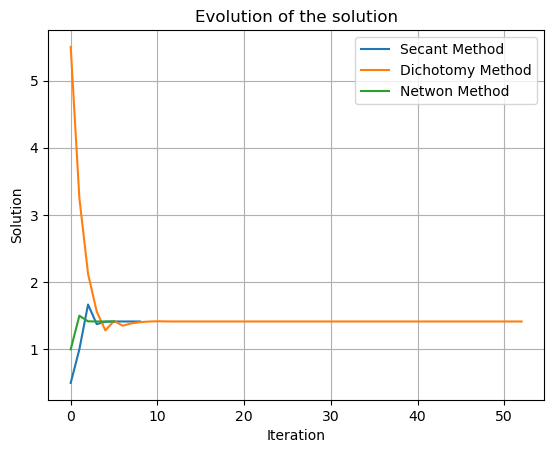

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

def dichot(f, a, b, epsilon, max_iter):
    '''Function to find solution to f using Dichotomy Method'''
    c = (a+b)/2
    evol = [c]
    error = []
    i = 0
    while abs(f(c))>epsilon and i<max_iter:
        if f(c) > 0:
            b = c
        else:
            a = c     
        cnew = (a+b)/2
        error.append(np.abs(cnew-c))
        c = cnew
        evol.append(c)
        i += 1
    return c, i, evol, error

def newton(f, df, c, epsilon, max_iter):
    '''Function to find solution to f using Newton Method'''
    evol = [c]
    error = []
    i = 0
    while abs(f(c))>epsilon and i<max_iter:
        c0 = c
        c = c - (f(c)/df(c))
        error.append(np.abs(c-c0))
        evol.append(c)
        i += 1
    return c, i, evol, error

def newton_sec(f, c0, c, epsilon, max_iter):
    '''Function to find solution to f using Newton Secant Method'''
    evol = [c0, c]
    error = []
    i = 0
    while abs(f(c))>epsilon and i<max_iter:
        df = (f(c) - f(c0))/(c-c0)
        cnew = c - f(c)/df
        evol.append(cnew)
        error.append(np.abs(cnew-c))
        c0 = c
        c = cnew
        i += 1
    return c, i, evol, error
##########################
#### Example Solution ####
##########################
# Parameters
init1 = 1 # Initial guess 1
init2 = 10 # Initial guess 2
epsilon = 1e-15 # Tolerance
max_iter = 100 # Stopping criteria if solution does not converge

fun = lambda x: x**2 - 2 # Function 
df = lambda x: 2*x # Derivative

# Caclulating the solutions
c_dic, i_dic, evol_dic, er_dic = dichot(fun, init1, init2, epsilon, max_iter)
c_new, i_new, evol_new, er_new = newton(fun, df, init1, epsilon, max_iter)
c_ns, i_ns, evol_ns, er_ns = newton_sec(fun, 0.5, 1, epsilon, max_iter)

print("Dichotomy:\n---------------\nIterations: {}\nSolution: {:.15f}".format(i_dic, c_dic))
print("\n\nNewton:\n---------------\nIterations: {}\nSolution: {:.15f}".format(i_new, c_new))
print("\n\nNewton Secant:\n---------------\nIterations: {}\nSolution: {:.15f}".format(i_ns, c_ns))

# Plotting the evolution
plt.figure
plt.plot(evol_ns)
plt.plot(evol_dic)
plt.plot(evol_new)
plt.title('Evolution of the solution')
plt.xlabel('Iteration')
plt.ylabel('Solution')
plt.legend(['Secant Method', 'Dichotomy Method', 'Netwon Method'])
plt.grid()
plt.show()

#### Question :

*Pour chaque algorithme, tracer un graphique permettant de retrouver l'ordre de convergence*

On rappelle que pour :
- la dichotomie : la suite d'approximation $x_{n+1}$ approchant la valeur $\alpha$ vérifie $\|x_{n+1} - \alpha\| \lt C \|x_{n} - \alpha\|^1$,la méthode est donc d'ordre 1. Donc en traçant $log(\|x_{n+1} - \alpha\|)$ en fonction de $log(\|x_{n+1} - \alpha\|)$, on devrait obtenir une droite de pente 1.
- la sécante : la suite d'approximation $x_{n+1}$ approchant la valeur $\alpha$ vérifie $\|x_{n+1} - x_{n}\| \lt C \|x_{n} - x_{n-1}\|^\beta$, $\beta$ étant le nombre d'or ($\beta=\frac{1+\sqrt5}{2}$).
- Newton : la suite d'approximation $x_{n+1}$ approchant la valeur $\alpha$ vérifie $\|x_{n+1} - x_{n}\| \lt C \|x_{n} - x_{n-1}\|^2$, la méthode est donc d'ordre 2.

Slope of the Newton Method Convergence: [[1.9904001]] ~ 2
Slope of the Secant Convergence: [[1.59079312]] ~ Golden Ratio: 1.618033988749895
Slope of the Dichotomy Convergence: [[0.98524488]] ~ 1

The slopes verify the expected convegence rates that are defined above this code block


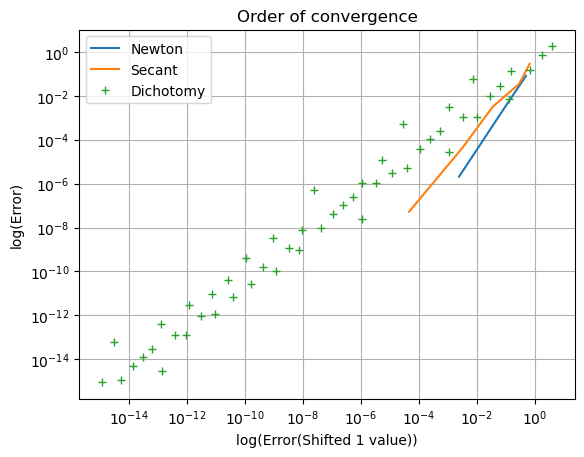

In [32]:
# Plotting the graph for dichotomy
from sklearn.linear_model import LinearRegression

# Plot of Convergence and the Slope of the Convergence for the Newton Method
plt.loglog(er_new[0:-2], er_new[1:-1], label='Newton')
mod_new = LinearRegression().fit(np.log(er_new[0:-2]).reshape(-1, 1),np.log(er_new[1:-1]).reshape(-1, 1))
print(f"Slope of the Newton Method Convergence: {mod_new.coef_} ~ 2")

# Plot of Convergence and the Slope of the Convergence for the Secant Method
plt.loglog(er_ns[0:-2], er_ns[1:-1], label='Secant')
mod_sc = LinearRegression().fit(np.log(er_ns[0:-2]).reshape(-1, 1),np.log(er_ns[1:-1]).reshape(-1, 1))
print(f"Slope of the Secant Convergence: {mod_sc.coef_} ~ Golden Ratio: {(1.+(5**0.5))/2}")

# Plot of Convergence and the Slope of the Convergence for the Dichotomy Method
abser = [abs(xi - 2**0.5) for xi in evol_dic]
plt.loglog(abser[0:-2], abser[1:-1], '+', label='Dichotomy')
mod_dic = LinearRegression().fit(np.log(abser[0:-2]).reshape(-1, 1),np.log(abser[1:-1]).reshape(-1, 1))
print(f"Slope of the Dichotomy Convergence: {mod_dic.coef_} ~ 1")
print(f"\nThe slopes verify the expected convegence rates that are defined above this code block")
plt.legend()
plt.xlabel('log(Error(Shifted 1 value))')
plt.ylabel('log(Error)')
plt.title('Order of convergence')
plt.grid()
plt.show()

### Résolution d'une équation complexe

On s’intéresse à la recherche des solutions complexes de l’équation $z^3 = 1$. Pour cela nous allons utiliser la méthode de Newton appliquée à la fonction vectorielle de 2 variables
$F : (x,y)->(Re((x+i y)^3-1),Im((x+i y)^3-1))$, fonction qui s'annule exactement lorsque $(x+i y)^3=1$.
On donne ci-dessous le code Python définissant cette fonction (que l'on compile via jit)

In [11]:
import numpy as np
from numba import jit, float64

@jit('float64[:](float64, float64)',nopython=True)
def F(x,y):
    return np.array([-1.+x**3-3.*x*y**2,3.*x**2*y-y**3])

#### Question :
*Justifier cette implémentation*

What we're doing here is creating a function for the real values of the roots and comparing to those to whats provided into the function, and similarly for the imaginary parts. 

This means that any x and y (Real and Imaginary Parts) that solve are the roots of the solution should balance out the function and make it equal to zero.

A similar strategy is applied for $z^5 = 1$ and $z^3 -2z + 2 = 0$ where the functions are now:
$F : (x,y)->(Re((x+i y)^5-1),Im((x+i y)^5-1))$

and 

$F : (x,y)->(Re((x+i y)^3 - 2*(x+i y) + 2),Im((x+i y)^3 - 2*(x+i y) + 2))$

#### Question :
Calculer les solutions de l'équation $z^3 = 1$ et vérifier en Python que la fonction vectorielle précédemment définie s'annule bien pour ces 3 valeurs

In [12]:
# z = e^(iPi*2K/3) = cos(Pi*2K/3) + isin(Pi*2K/3) where K = 0, 1, 2
theta1 = 0*np.pi/3 # Angle 1
theta2 = 2*np.pi/3 # Angle 2
theta3 = 4*np.pi/3 # Angle 3

F1 = F(np.cos(theta1),np.sin(theta1))
F2 = F(np.cos(theta2),np.sin(theta2))
F3 = F(np.cos(theta3),np.sin(theta3))

assert(np.allclose(F1, 0, 1e-6))
assert(np.allclose(F2, 0, 1e-6))
assert(np.allclose(F3, 0, 1e-6))

print('The solutions cancel out which means the Function is the correct solution')

The solutions cancel out which means the Function is the correct solution


#### Question :
Définir une fonction DF qui retourne la différentielle de la F (sa matrice Jacobienne).

In [13]:
from numba import jit, float64

@jit('float64[:,:](float64, float64)',nopython=True)
def DF(x,y):
    return np.array([[3.*x**2-3.*y**2, -6*x*y],[6.*x*y,3*x**2-3.*y**2]])

#### Question :
Définir une fonction Newton, qui pour une initialisation donnée et une tolérance fixée calcule et retourne les valeurs des parties réelle et imaginaire de la solution de l'équation $z^3 = 1$. On retournera également le nombre d'itérations pour atteindre la tolérance (que l'on limitera à 100).

In [14]:
import numpy as np
import numpy.linalg as la

def newtonC(F, DF, z0, epsilon, nmax_iter, roots):
    '''Newton Method for complex problems'''
    
    # Initializing variables 
    x, y = z0.real, z0.imag
    iters = 0
    # Defining error criterion by function being 0
    error = la.norm(F(x, y))
    while  error > epsilon and iters < nmax_iter:
        '''Loop until the function approaches zero'''
        dx, dy = la.solve(DF(x, y), F(x, y))
        x, y = x - dx, y - dy
        error = la.norm(F(x, y))
        iters += 1
    if iters == nmax_iter:
        root_index = -1 # No solution reached
    else:
        # Find the closest root
        dist = [la.norm(complex(x,y) - (root)) for root in roots]
        root_index = np.argmin(dist)+1
    return x, y, iters, roots, root_index

##########################
#### Example Solution ####
##########################
# Parameters
z0 = 2+2j # Initial Guess
epsilon = 1e-6
nmax_iter = 100

org_roots = [np.exp(2j * np.pi * k / 3) for k in range(0,3)] 
x, y, iters, _, _ = newtonC(F, DF, z0, epsilon, nmax_iter, org_roots)

if iters<=nmax_iter:
    print(f'''The number of iterations taken are: {iters}
The solution for initial guess{z0} is: {complex(x, y)}''')

The number of iterations taken are: 8
The solution for initial guess(2+2j) is: (1.000000073100373-5.7908035312566526e-08j)


On choisit maintenant l'initialisation dans une grille couvrant le carré $[−1.5, 1.5] \times [−1.5, 1.5]$ de pas $h = 3/n$, $n$ étant un entier.
En choisissant comme initialisation chaque point de la grille $(x_i , y_j )$, on résoud alors $F(x, y) = 0$ par la méthode de Newton et on mémorise dans un premier tableau, on mémorisera le numéro $k$ entre 1 et 3 de la racine $exp(2ik\pi/3)$ vers lequel l’algorithme aura convergé. Dans un deuxième tableau, on mémorisera le nombre d'itération pour converger. 
#### Question :
Programmer cette recherche.

In [15]:
import numpy as np

def search_fn(n, gp, taille, centre, org_roots = org_roots):
    '''Function to search for the solutions in the grid and the iterations
    take to converge, with the index of the root that is found'''
    # Step
    h = (taille*2)/n
    
    # Creating the grid
    gx = np.arange(-taille + centre[0], taille + centre[0], h)
    gy = np.arange(-taille + centre[1], taille + centre[1], h)
    
    # Parameters
    epsilon = 1e-6
    nmax_iter = 100
    tab_iter = np.zeros((n,n), dtype=int)
    tab_root = np.zeros((n,n), dtype=int)
    for i, x in enumerate(gx):
        for j, y in enumerate(gy):  
            _, _, iters, _, root_index = newtonC(F, DF, complex(x, y), epsilon, nmax_iter, org_roots)
            tab_iter[i, j] = iters
            tab_root[i, j] = root_index
    return tab_iter, tab_root

#### Question :

*À partir des résultats précédents construire une image de taille $n \times n$. Chaque point de cette image prend une couleur différente en fonction de la racine vers laquelle l'algorithme a convergé. La teinte de cette couleur sera pondérée par le nombre d'itérations nécessaires pour converger (le codage de couleurs HSV est adapté à la description précédente, il faudra ensuite la convertir en RGB pour créer l'image).*

In [16]:
import matplotlib.pyplot as plt
import colorsys as col

def plot_search(n, tab_iter, tab_root,nr=3, plot_nc = 0, scale=4):
    '''Function for plotting the solution in complex plane with RGB colorspace,
    Extra Parameters:
        plot_nc = 1 # For adding an extra color for the points where
                    the solution does not converge
        scale = 4 # Default value for scaling the Value parameter in HSV space'''
    im = np.zeros([n,n, 3]) # Initialization of image
    maxval = np.max(tab_iter)
    minval = np.min(tab_iter)
    roots = np.arange(1, nr+1)
    roots = roots if plot_nc == 0 else np.append(roots, -1)
    hues = [((360./(nr+plot_nc))/2 + (360./(nr+plot_nc))*n)/360. for n in range(nr+plot_nc)]
    for i in range(n):
        for j in range(n):
            V = ((maxval - tab_iter[i, j])/(maxval -minval))**scale if plot_nc == 0 else ((maxval*0.5 - tab_iter[i, j])/(maxval*0.5 -minval))**scale 
            S = 1.
            cur_root = tab_root[i, j]
            a = np.where(roots==cur_root)
            a = a[0]
            H = hues[a[0]] if len(a) == 1 else 0
          # Conditions for different number of roots and whether to fill nonconverged solutions
            Red, Blue, Green = col.hsv_to_rgb(H, S, V)
            im[j, i] = [Red, Green, Blue]
  # Show the image and make it look nicer
    plt.imshow(im)
    f1 = plt.gca()
    f1.axes.get_xaxis().set_ticks([])
    f1.axes.get_yaxis().set_ticks([])

For an example case:
The number of iterations taken are: 8
The solution for the initial guess (2+2j) is: (1.000000073100373-5.7908035312566526e-08j)
############################################################################

The Netwon method over the grid [-1.5,1.5] x [-1.5,1.5] gives the following plot:



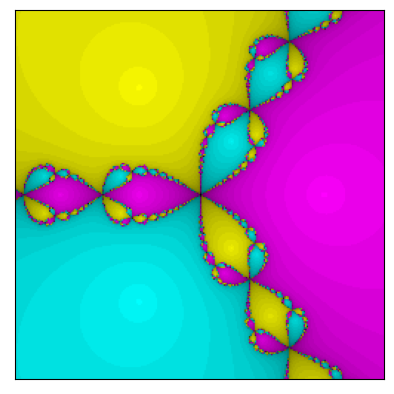

In [24]:
# Parameters
z0 = 2+2j # Initial guess for Newton Method
epsilon = 1e-6 # Max error
nmax_iter = 100 # Max iterations for the Newton Method
n = 250  # Number of discretization points
gp = 1.5 # Grid point extreme
taille = 1.5 # Size of the grid
centre = [0,0] # Center of the plot

# Function definition and the derivatives
@jit('float64[:](float64, float64)',nopython=True)
def F(x,y):
    return np.array([-1.+x**3-3.*x*y**2,3.*x**2*y-y**3])

@jit('float64[:,:](float64, float64)',nopython=True)
def DF(x,y):
    return np.array([[3.*x**2-3.*y**2, -6*x*y],[6.*x*y,3*x**2-3.*y**2]])

# Original roots for the equation z^3 -1 = 0
org_roots = [np.exp(2j * np.pi * k / 3) for k in range(0,3)]
org_roots = [np.exp(1j * 0), np.exp(1j * 2.0944), np.exp(-1j * 2.0944)]
# Newton Method on the grid
x, y, iters, _, root_index = newtonC(F, DF, z0, epsilon, nmax_iter, org_roots)

if iters<=nmax_iter:
    print(f'''For an example case:\nThe number of iterations taken are: {iters}
The solution for the initial guess {z0} is: {complex(x, y)}''')
    
######################################################

# Grid Search
tab_iter, tab_root = search_fn(n, gp, taille, centre, org_roots)

#print(f"The table of iterations is defined as: \n{tab_iter}")
#print(f"\nThe table of root indexes is defined as: \n{tab_root}\nwhere the \
#integer is the k value" )

######################################################

# Plot the curves
# Plot the curves
print(f"############################################################################\n\n\
The Netwon method over the grid [{-gp},{gp}] x [{-gp},{gp}] gives the following plot:\n")
plot_search(n, tab_iter, tab_root, len(org_roots), plot_nc=0)

#### Question :
* Constuire une nouvelle image, mais cette fois sur le domaine de taille  $ 0.2 \times 0.2$ centré en $[0.5,0.5]$. Que peut-on conjecturer sur la nature de cette représentation graphique ?*

We can see that this is equaivalent to zooming in on the fractals, where we that the fractals follow a recursive patterns of where the roots will converge. If we keep zooming will keep finding the fractals which are synchronous to the one that we got in [-1.5, -1.5]x[-1.5, 1.5] grid


############################################################################

The Netwon method over the grid [-0.2,0.2] x [-0.2,0.2] gives the following plot:



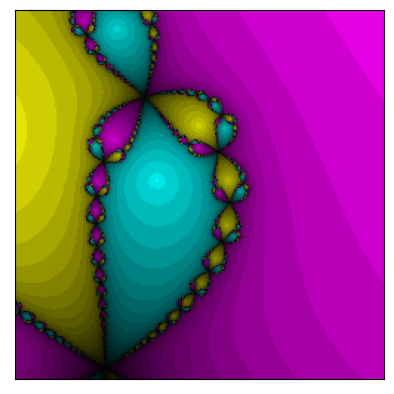

In [25]:
# Parameters
z0 = 2+2j # Initial guess for Newton Method
epsilon = 1e-6 # Max error
nmax_iter = 100 # Max iterations for the Newton Method
n = 250 # Number of discretization points
gp = 0.2 # Grid point extreme
taille = 0.2 # Size of the grid
centre = [0.5,0.5] # Center of the plot

tab_iter, tab_root = search_fn(n, gp, taille, centre, org_roots)

# Plot the curves
print(f"We can see that this is equaivalent to zooming in on the fractals, where we \
that the fractals follow a recursive patterns of where the roots will converge. If \
we keep zooming will keep finding the fractals which are synchronous to the one that \
we got in [-1.5, -1.5]x[-1.5, 1.5] grid\n\n")
print(f"############################################################################\n\n\
The Netwon method over the grid [{-gp},{gp}] x [{-gp},{gp}] gives the following plot:\n")
plot_search(n, tab_iter, tab_root, len(org_roots), plot_nc=0)

#### Question :

*Reprendre la méthode précédente et construire l'image associée à la recherche des zéros du polynome $p(z) = z^3 - 2z + 2$. On ajoutera une couleur pour les points ou l'algorithme de Newton ne converge pas.*

*On peut aussi s'intéresser à $p(z) = z^5-1$.*

The number of iterations taken are: 6
The solution for the initial guess (2+2j) is: (0.8846461758746526+0.58974280382548j)
############################################################################

The Netwon method over the grid [-1.5,1.5] x [-1.5,1.5] gives the following plot:



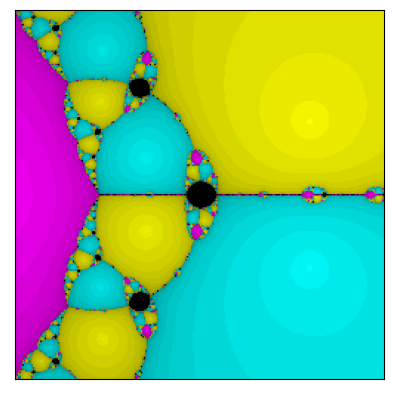

In [34]:
# Parameters
z0 = 2+2j # Initial guess for Newton Method
epsilon = 1e-6 # Max error
nmax_iter = 100 # Max iterations for the Newton Method
n = 250 # Number of discretization points
gp = 1.5 # Grid point extreme
taille = 1.5 # Size of the grid
centre = [0,0] # Center of the plot

# Function definition and the derivatives
@jit('float64[:](float64, float64)',nopython=True)
def F(x,y):
    return np.array([2.+x**3-3.*x*y**2 -2*x,3.*y*x**2-y**3 -2*y])

@jit('float64[:,:](float64, float64)',nopython=True)
def DF(x,y):
    return np.array([[3.*x**2-3.*y**2 -2, -6*x*y],[6.*x*y,3*x**2-3.*y**2-2]])
# Original roots for the equation z^3 -2z + 2 = 0
org_roots = [1.7693 * np.exp(1j*3.1416), 1.0632*np.exp(1j*0.5880), 1.0632*np.exp(-1j*0.5880)]
# Newton Method on the grid
x, y, iters, _, root_index = newtonC(F, DF, z0, epsilon, nmax_iter, org_roots)

if iters<=nmax_iter:
    print(f'''The number of iterations taken are: {iters}
The solution for the initial guess {z0} is: {complex(x, y)}''')
    
######################################################

# Grid Search
tab_iter, tab_root = search_fn(n, gp, taille, centre, org_roots)

#print(f"The table of iterations is defined as: \n{tab_iter}")
#print(f"\nThe table of root indexes is defined as: \n{tab_root}\nwhere the \
#integer is the k value" )

######################################################

# Plot the curves
print(f"############################################################################\n\n\
The Netwon method over the grid [{-gp},{gp}] x [{-gp},{gp}] gives the following plot:\n")
plot_search(n, tab_iter, tab_root, len(org_roots), plot_nc=0)

### Adding a color for points not converged

After adding another color for the points where the solution does not converge:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


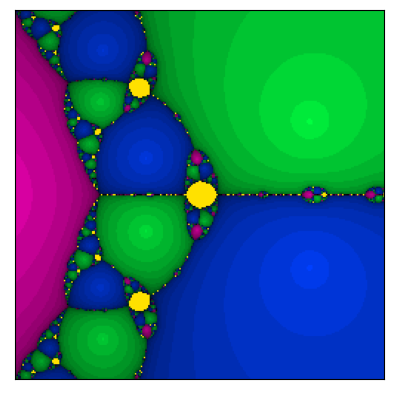

In [35]:
# Adding another color for points where the solution does not converge
print("After adding another color for the points where the solution does not converge:\n")
plot_search(n, tab_iter, tab_root, len(org_roots), plot_nc=1)

The Newton Method works!
The number of iterations taken are: 12
The solution for the initial guess (2+2j) is: (0.3090169939884168+0.9510565165359223j)
##############################################################################

The Netwon method over the grid [-1.5,1.5] x [-1.5,1.5] gives the following plot:



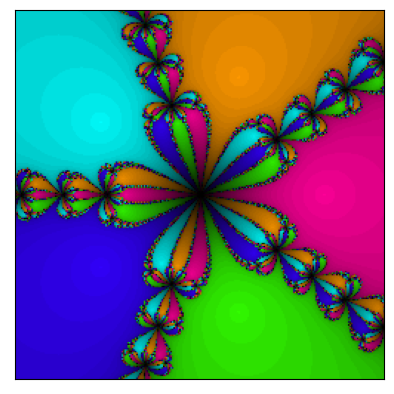

In [28]:
# Parameters
z0 = 2+2j # Initial guess for Newton Method
epsilon = 1e-6 # Max error
nmax_iter = 100 # Max iterations for the Newton Method
n = 250 # Number of discretization points
gp = 1.5 # Grid point extreme
taille = 1.5 # Size of the grid
centre = [0,0] # Center of the plot

# Function definition and the derivatives
@jit('float64[:](float64, float64)',nopython=True)
def F(x,y):
    return np.array([x**5 - 10.*(x**3)*(y**2) +5.*x*y**4 - 1, 5.*y*x**4 - 10.*(y**3)*(x**2) + y**5])

@jit('float64[:,:](float64, float64)',nopython=True)
def DF(x,y):
    return np.array([[5.*x**4 -30.*(x**2)*(y**2) + 5.*y**4,-20.*y*x**3 + 20.*x*y**3],[-(-20.*y*x**3 + 20.*x*y**3),5.*x**4 -30.*(x**2)*(y**2) + 5.*y**4]])

# Original roots for the equation z^5 -1 = 0
org_roots = [np.exp(1j * np.pi * (2*k + 1) / 3) for k in range(-2,3)]
org_roots = [np.exp(1j * 0), np.exp(1j * 2.5133), np.exp(-1j * 2.5133), np.exp(1j * 1.2566),np.exp(-1j * 1.2566)]

# Newton Method
x, y, iters, _, root_index = newtonC(F, DF, z0, epsilon, nmax_iter, org_roots)

if iters<=nmax_iter:
    print(f'''The Newton Method works!\nThe number of iterations taken are: {iters}
The solution for the initial guess {z0} is: {complex(x, y)}''')
    
######################################################

# Grid Search and tabulate in two tables, the iterations and the roots
# -1 is the root if the Newton method doesn't converge
tab_iter, tab_root = search_fn(n, gp, taille, centre, org_roots)

# print(f"The table of iterations is defined as: \n{tab_iter}")
# print(f"\nThe table of root indexes is defined as: \n{tab_root}\nwhere the \
# integer is the k value" )

######################################################

# Plot the curves
# Change plot_nc = 0 to 1, if you want to replace the non-converged points by another color
print(f"##############################################################################\n\n\
The Netwon method over the grid [{-gp},{gp}] x [{-gp},{gp}] gives the following plot:\n")
plot_search(n, tab_iter, tab_root, len(org_roots), plot_nc=0)

### Adding a color for points not converged

After adding another color for the points where the solution does not converge:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


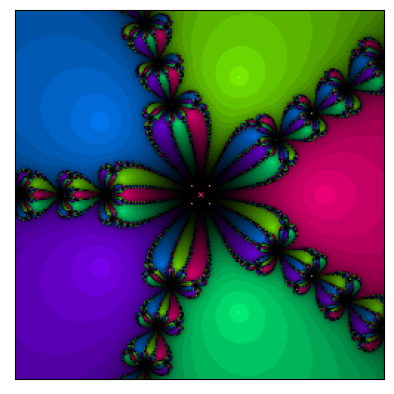

In [29]:
# Adding another color for points where the solution does not converge
print("After adding another color for the points where the solution does not converge:\n")
plot_search(n, tab_iter, tab_root, len(org_roots), plot_nc=1)